In [334]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import Imputer
import seaborn as sns
%matplotlib inline
from sklearn.tree import export_graphviz
import graphviz

# Data loading and cleaning

In [4]:
df = pd.read_csv("imdb-5000-movie-dataset.zip")

In [5]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [6]:
df.shape

(5043, 28)

In [8]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [7]:
target = "imdb_score"


In [17]:
(df.isnull().sum() / float(len(df))) < 0.1

color                         True
director_name                 True
num_critic_for_reviews        True
duration                      True
director_facebook_likes       True
actor_3_facebook_likes        True
actor_2_name                  True
actor_1_facebook_likes        True
gross                        False
genres                        True
actor_1_name                  True
movie_title                   True
num_voted_users               True
cast_total_facebook_likes     True
actor_3_name                  True
facenumber_in_poster          True
plot_keywords                 True
movie_imdb_link               True
num_user_for_reviews          True
language                      True
country                       True
content_rating                True
budget                        True
title_year                    True
actor_2_facebook_likes        True
imdb_score                    True
aspect_ratio                  True
movie_facebook_likes          True
dtype: bool

In [18]:
def drop_columns_with_too_many_nas(df, threshold=0.1):
    na_proportions = df.isnull().sum() / float(len(df))
    columns_to_keep = na_proportions[na_proportions < threshold].index.tolist()
    return df[columns_to_keep]

In [19]:
df_no_many_na = drop_columns_with_too_many_nas(df)

In [30]:
df_dummified = pd.get_dummies(df_no_many_na)

In [44]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_numeric = df_no_many_na.select_dtypes(include=numerics)

In [45]:
df_no_na = Imputer(strategy="mean").fit_transform(df_numeric)

In [46]:
target_index = df_numeric.columns.tolist().index(target)
target_index

12

In [50]:
y = df_no_na[:, target_index]
x = np.delete(df_no_na, target_index, axis=1)

In [51]:
y.shape, x.shape

((5043,), (5043, 14))

In [291]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [53]:
y_train.shape, x_train.shape

((3782,), (3782, 14))

# First model

In [55]:
tree_model = DecisionTreeRegressor(max_depth=4)
tree_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [112]:
tree_model.score(x_test, y_test)

0.28233990637798645

In [73]:
predictions_vs_realite = pd.DataFrame({"predictions": tree_model.predict(x_test),
              "realite": y_test})
predictions_vs_realite

,predictions,realite
0,6.576020,6.5
1,6.198316,5.4
2,5.769258,7.2
3,7.304472,8.0
4,6.198316,4.6
5,6.198316,6.9
6,6.198316,4.6
7,6.929719,7.5
8,6.929719,7.3
9,6.198316,5.4


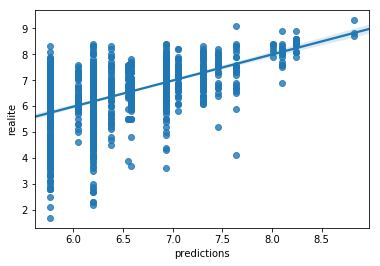

In [86]:
p = sns.regplot(predictions_vs_realite.predictions, 
            predictions_vs_realite.realite)

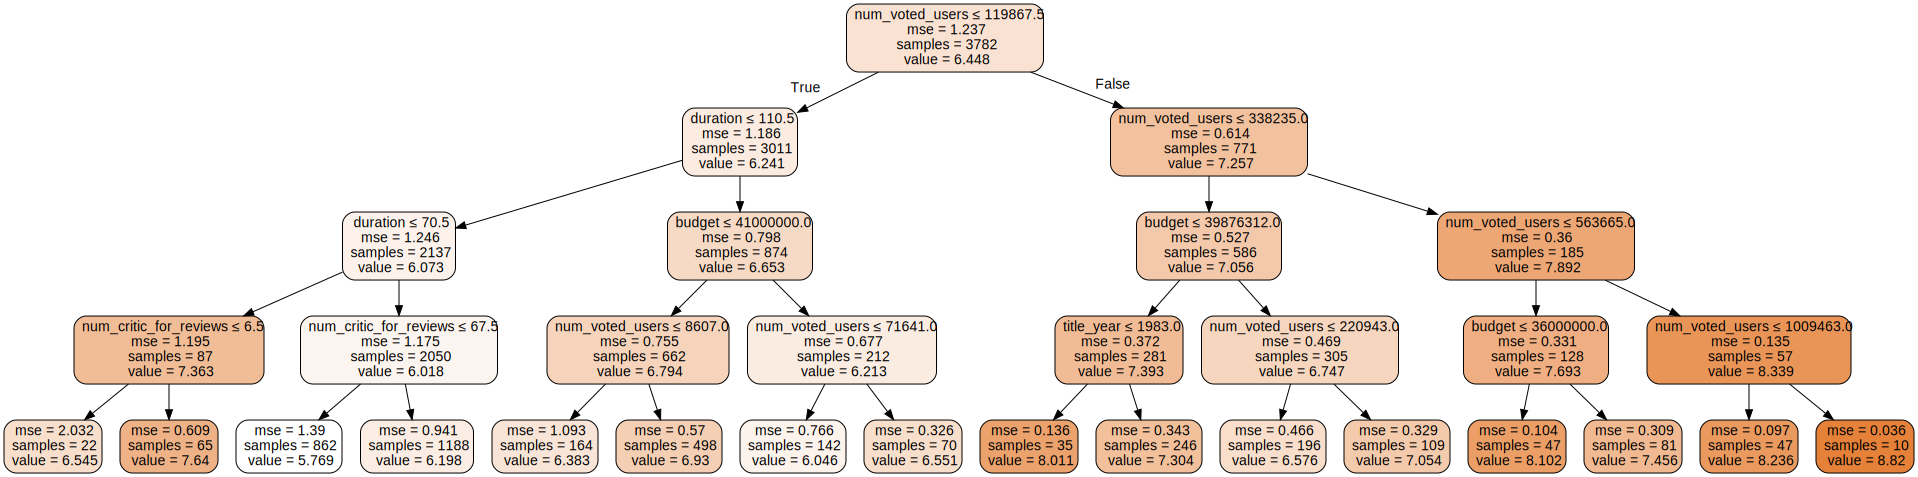

In [111]:
dot_data_tree = export_graphviz(tree_model, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True) 
graphviz.Source(dot_data_tree)

# CV

In [61]:
params_grid = {"max_depth": [None] + list(range(2, 12)), 
               "min_samples_split": np.linspace(0.01, 0.3, 30), 
               "min_samples_leaf": np.linspace(0.01, 0.3, 30),
              "max_features": ["auto", "sqrt", "log2", None]}


In [67]:
best_decision_tree = GridSearchCV(cv=6, param_grid=params_grid, estimator=DecisionTreeRegressor())

In [68]:
best_decision_tree.fit(x_train, y_train, n_jobs=-1)

GridSearchCV(cv=6, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ]), 'min_sample...   0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ]), 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [122]:
best_params = best_decision_tree.best_params_
best_params

{'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 0.01,
 'min_samples_split': 0.019999999999999997}

In [99]:
best_tree = DecisionTreeRegressor(**best_decision_tree.best_params_)
best_tree = best_tree.fit(x_train, y_train)

In [113]:
best_tree.score(x_test, y_test)

0.3730724799035893

In [100]:
predictions_vs_realite_cv = pd.DataFrame({"predictions": best_tree.predict(x_test),
              "realite": y_test})
predictions_vs_realite_cv

,predictions,realite
0,6.053333,6.5
1,6.750725,5.4
2,5.377612,7.2
3,7.930952,8.0
4,5.777535,4.6
5,6.694783,6.9
6,5.777535,4.6
7,6.726667,7.5
8,6.726667,7.3
9,5.777535,5.4


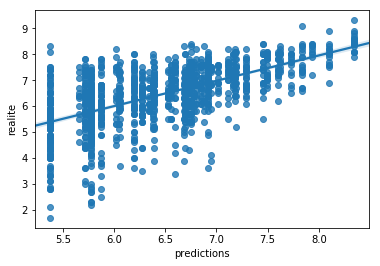

In [101]:
sns.regplot(predictions_vs_realite_cv.predictions, 
            predictions_vs_realite_cv.realite)

In [94]:
features = [x for x in df_numeric.columns if x != target]

In [106]:
dot_data = export_graphviz(best_tree, out_file=None, 
                         feature_names=features,  
                         filled=True, rounded=True,  
                         special_characters=True) 

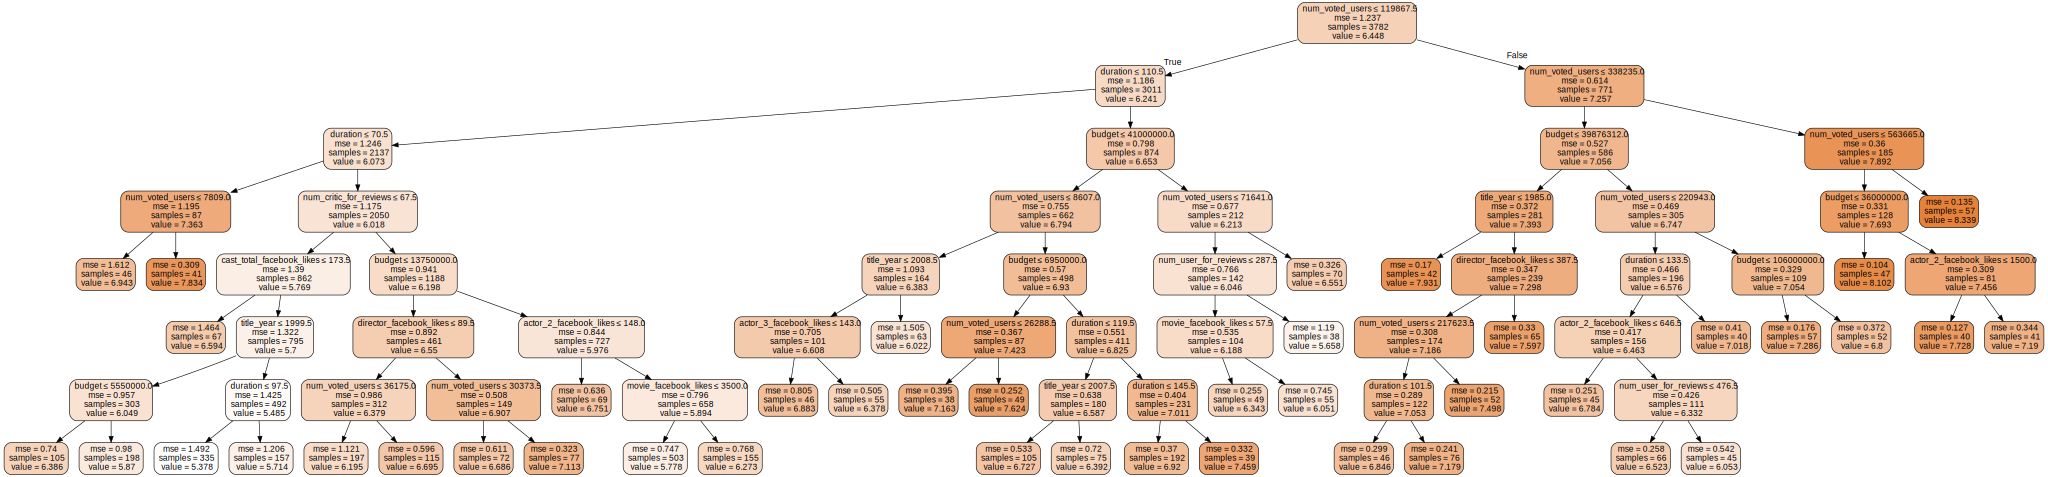

In [109]:
graphviz.Source(dot_data)

# Foret

In [322]:
n_samples = 1000
#sample_size = 1000
sample_size = x_train.shape[0]
pool_size = x_train.shape[0]

def get_sample(pool_size=pool_size, sample_size=sample_size):
    return np.random.choice(range(pool_size), size=sample_size, replace=True)

samples = [get_sample() for _ in range(n_samples)]

In [323]:
def train_individual_tree(sample):
    x_train_sample = x_train[sample, :]
    y_train_sample = y_train[sample]
    tree_sample = DecisionTreeRegressor(max_depth=50)
    return tree_sample.fit(x_train_sample, y_train_sample)
    
tree_samples = list(map(train_individual_tree, samples))

In [324]:
predictions_tree_samples = list(map(lambda tree: tree.predict(x_test), tree_samples))

In [325]:
bootstrap_predictions = sum(predictions_tree_samples) / n_samples
r2_score(y_test, bootstrap_predictions)

0.47927075240699224

In [187]:
predictions_vs_realite_bootstrap = pd.DataFrame({"predictions": bootstrap_predictions,
              "realite": y_test})
predictions_vs_realite_bootstrap

,predictions,realite
0,6.540141,6.5
1,6.330611,5.4
2,5.502983,7.2
3,7.571647,8.0
4,5.807596,4.6
5,6.306137,6.9
6,5.647791,4.6
7,6.997460,7.5
8,6.700341,7.3
9,5.945527,5.4


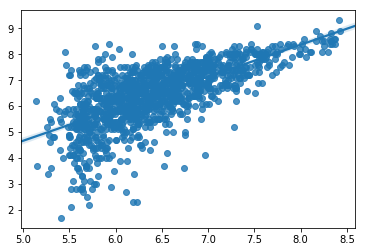

In [188]:
sns.regplot(bootstrap_predictions, 
            y_test)

## Comparison with sklearn random forest

In [326]:
rf = RandomForestRegressor(max_depth=50, n_estimators=1000, n_jobs=-1)

In [327]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [328]:
rf.score(x_test, y_test)

0.47915084136368824

# Feature sampling

In [329]:
frac = 0.8
num_features = x_train.shape[1]


def get_feature_sample(num_features=num_features, frac=frac):
    return np.random.choice(range(num_features), size=int(frac * num_features), replace=False)

feature_samples = [get_feature_sample() for _ in range(n_samples)]

In [330]:
def train_individual_tree_bagging(sample, feature_sample):
    x_train_sample = x_train[sample, :][:, feature_sample]
    y_train_sample = y_train[sample]
    tree_sample = DecisionTreeRegressor(max_depth=50)
    return tree_sample.fit(x_train_sample, y_train_sample)
    
tree_samples_features = list(map(lambda s: train_individual_tree_bagging(s[0], s[1]), 
                        zip(samples, feature_samples)))

In [331]:
predictions_tree_samples_features = list(map(lambda s: s[0].predict(x_test[:, s[1]]), 
                                             zip(tree_samples_features, feature_samples)))

In [332]:
predictions_tree_samples_features

[array([5.4, 6.6, 7.5, ..., 7.8, 7.3, 6. ]),
 array([5. , 7.7, 6.5, ..., 8. , 5.5, 6.9]),
 array([5.9, 8.1, 7.3, ..., 8.5, 4.4, 6.2]),
 array([6.1, 7.4, 7.2, ..., 8.1, 6. , 6.5]),
 array([4.9, 6.5, 6.9, ..., 7.7, 5.6, 6.2]),
 array([2.3, 6.7, 7.2, ..., 8.3, 5.8, 7.1]),
 array([4.9, 7.3, 4.8, ..., 8. , 4.4, 6. ]),
 array([4.9, 7. , 8.1, ..., 8.1, 5.6, 5.8]),
 array([7.5, 5. , 7.5, ..., 8.2, 4.6, 6.6]),
 array([4.9, 6.5, 7.5, ..., 8.2, 4.7, 6.8]),
 array([4.9, 6.1, 5.3, ..., 8. , 4.5, 6.6]),
 array([4.4, 7.1, 7.4, ..., 7.7, 5.4, 6.2]),
 array([5.8, 7.3, 7.3, ..., 8.1, 2.9, 6.8]),
 array([5.6, 7.3, 7.1, ..., 8.2, 5.6, 6.2]),
 array([6.7, 5.2, 7.3, ..., 8.2, 5.2, 6.5]),
 array([7.4, 7.2, 6.9, ..., 8.3, 5.8, 6.6]),
 array([6.5, 6.5, 6.4, ..., 8.3, 4.6, 7.2]),
 array([6.3, 7.1, 6.7, ..., 8. , 5.2, 6.6]),
 array([6.7, 7.3, 7.3, ..., 8.1, 5.1, 8. ]),
 array([7.2, 7.1, 6.9, ..., 7.7, 3.6, 6. ]),
 array([4.8, 5.3, 6.6, ..., 7.9, 6.3, 6.2]),
 array([4.9, 6.4, 7.3, ..., 8.1, 4.5, 5.7]),
 array([6.

In [333]:
bootstrap_predictions_features = sum(predictions_tree_samples_features) / n_samples
r2_score(y_test, bootstrap_predictions_features)

0.4795796234387253

In [280]:
x_train.shape

(3782, 14)

In [288]:
feature_samples[0].shape

(11,)

In [282]:
samples[0]

array([2204, 1763, 2182, ..., 1837, 1991, 2007])

In [285]:
x_train[samples[0], feature_samples[0]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3782,) (11,) 

In [298]:
x_train_all_features = x_train[samples[0], :][:, feature_samples[0]]

In [299]:
x_train_all_features.shape

(3782, 11)

In [296]:
x_train_feature_sample = x_train_all_features[:, feature_samples[0]]

In [297]:
x_train_feature_sample.shape

(3782, 11)

# KNN

In [335]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [336]:
knn.score(x_test, y_test)

0.12205945066553624

In [338]:
list(range(4, 12, 4))

[4, 8]

In [345]:
knn_params_space = {"n_neighbors": list(range(5, 105, 2)),
                   "weights": ["uniform", "distance"]}

In [346]:
best_knn = GridSearchCV(cv=6, param_grid=knn_params_space, estimator=KNeighborsRegressor())

In [347]:
best_knn.fit(x_train, y_train)

GridSearchCV(cv=6, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [349]:
knn_best = best_knn.best_estimator_

In [350]:
knn_best.fit(x_train, y_train)
knn_best.score(x_test, y_test)

0.1918602058646739

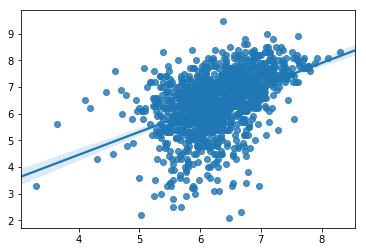

In [351]:
p = sns.regplot(knn_best.predict(x_test), 
            y_test)